In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


!ls "/content/drive/MyDrive/STA457_Project"

Mounted at /content/drive
a.ipynb		       Ghana_data.csv	   monthly_aggregated_data.csv
arimax.ipynb	       IV_data.csv	   Monthly_Average_Cocoa_Prices.csv
Daily_Prices_ICCO.csv  main.ipynb	   three_day_aggregated_data.csv
DataAggregation.ipynb  main_monthly.ipynb  weekly_aggregated_data.csv
final.csv	       main_weekly.ipynb   weekly_with_usd_open.csv


# Data Cleaning and Aggregation

In [5]:
import pandas as pd

prices_df = pd.read_csv("/content/drive/MyDrive/STA457_Project/Daily_Prices_ICCO.csv",
                        parse_dates=["Date"],
                        dayfirst=True)

prices_df.rename(columns={"ICCO daily price (US$/tonne)": "price"}, inplace=True)

# convert 'price' from strings with commas to float
prices_df["price"] = (prices_df["price"]
                        .replace({",": ""}, regex=True)
                        .astype(float))

# set date as index for resampling
prices_df.set_index("Date", inplace=True)

# aggregate on weekly level
weekly_price = prices_df.resample("W").mean()


# Côte d’Ivoire weather data
ci_df = pd.read_csv("/content/drive/MyDrive/STA457_Project/IV_data.csv", parse_dates=["DATE"])
ci_df.set_index("DATE", inplace=True)

# clean and drop columns we dont want
for col in ["PRCP", "TAVG", "TMAX", "TMIN"]:
    if col in ci_df.columns:
        ci_df[col] = pd.to_numeric(ci_df[col], errors="coerce")

# aggregate temperature by mean and precipitation by weekly sum
weekly_ci = ci_df.resample("W").agg({
    "PRCP": "sum",
    "TAVG": "mean",
    "TMAX": "mean",
    "TMIN": "mean"
})

# rename columns to indicate these are from Côte d’Ivoire
weekly_ci.rename(columns={
    "PRCP": "PRCP_CI",
    "TAVG": "TAVG_CI",
    "TMAX": "TMAX_CI",
    "TMIN": "TMIN_CI"
}, inplace=True)

# Ghana weather data
gh_df = pd.read_csv("/content/drive/MyDrive/STA457_Project/Ghana_data.csv", parse_dates=["DATE"])
gh_df.set_index("DATE", inplace=True)

# convert PRCP, TAVG, TMAX, TMIN to numeric
for col in ["PRCP", "TAVG", "TMAX", "TMIN"]:
    if col in gh_df.columns:
        gh_df[col] = pd.to_numeric(gh_df[col], errors="coerce")

# aggregate temperature by mean and precipitation by weekly sum
weekly_gh = gh_df.resample("W").agg({
    "PRCP": "sum",
    "TAVG": "mean",
    "TMAX": "mean",
    "TMIN": "mean"
})

# rename columns to indicate these are from Ghana
weekly_gh.rename(columns={
    "PRCP": "PRCP_GH",
    "TAVG": "TAVG_GH",
    "TMAX": "TMAX_GH",
    "TMIN": "TMIN_GH"
}, inplace=True)

print("Prices date range:", prices_df.index.min(), prices_df.index.max())
print("CI date range:", ci_df.index.min(), ci_df.index.max())
print("GH date range:", gh_df.index.min(), gh_df.index.max())


# combine data
weekly_all = weekly_price.join([weekly_ci, weekly_gh], how="inner")

# filling missing values with the mean of the respective columns
weekly_all.fillna(weekly_all.mean(), inplace=True)

weekly_all = weekly_all.reset_index()
weekly_all.rename(columns={'index': 'date'}, inplace=True)

print(weekly_all.head(10))

# save csv
weekly_all.to_csv("/content/drive/MyDrive/STA457_Project/weekly_aggregated_data.csv", index=False)

Prices date range: 1994-10-03 00:00:00 2025-02-27 00:00:00
CI date range: 1990-01-01 00:00:00 2025-03-26 00:00:00
GH date range: 1990-01-01 00:00:00 2025-03-26 00:00:00
        date     price  PRCP_CI    TAVG_CI    TMAX_CI    TMIN_CI  PRCP_GH  \
0 1994-10-09  1441.174    784.3  25.694737  30.044828  21.968116      8.4   
1 1994-10-16  1413.432    337.7  25.860674  29.956716  21.651220     27.9   
2 1994-10-23  1455.436     39.1  25.138462  30.000000  22.066667      0.0   
3 1994-10-30  1474.974    317.3  26.384375  30.374138  21.385185      1.0   
4 1994-11-06  1462.408    175.7  26.351685  30.883529  21.772131      4.1   
5 1994-11-13  1428.192     35.8  27.172464  31.629032  21.089286      0.0   
6 1994-11-20  1445.166     95.9  27.076812  31.741791  21.379412      0.0   
7 1994-11-27  1457.804     66.5  26.994937  32.185938  21.105556      0.0   
8 1994-12-04  1372.096     39.9  27.208163  32.179121  20.981818      0.0   
9 1994-12-11  1374.680      0.0  25.448810  30.995122  18.901

#EDA

=== HEAD ===
        date     price  PRCP_CI    TAVG_CI    TMAX_CI    TMIN_CI  PRCP_GH  \
0 1994-10-09  1441.174    784.3  25.694737  30.044828  21.968116      8.4   
1 1994-10-16  1413.432    337.7  25.860674  29.956716  21.651220     27.9   
2 1994-10-23  1455.436     39.1  25.138462  30.000000  22.066667      0.0   
3 1994-10-30  1474.974    317.3  26.384375  30.374138  21.385185      1.0   
4 1994-11-06  1462.408    175.7  26.351685  30.883529  21.772131      4.1   

     TAVG_GH    TMAX_GH  TMIN_GH  
0  26.642857  31.465783   23.100  
1  25.828571  27.100000   22.775  
2  27.933333  31.465783   23.300  
3  26.816667  29.633333   23.525  
4  27.960000  30.800000   22.900  

=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1587 non-null   datetime64[ns]
 1   price    1587 non-null   float64       
 2   PRCP_CI 

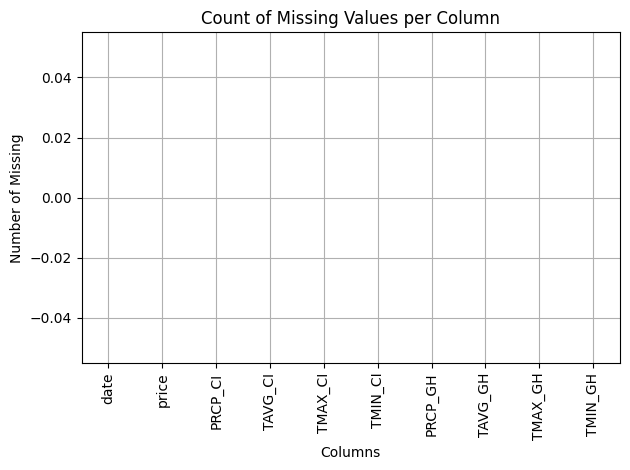

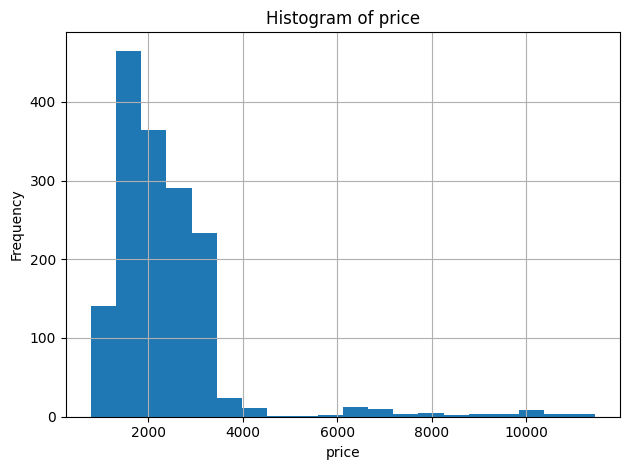

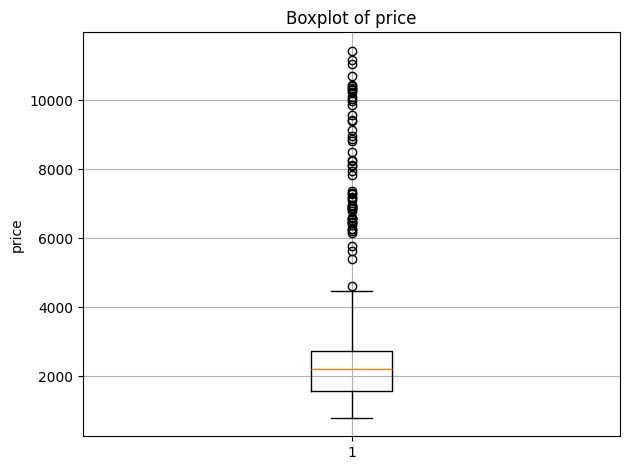

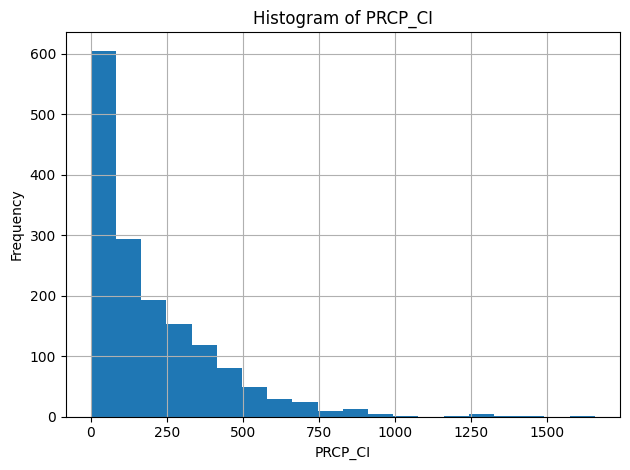

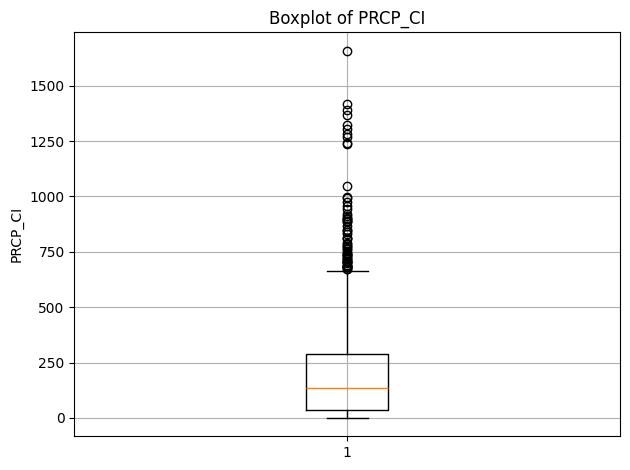

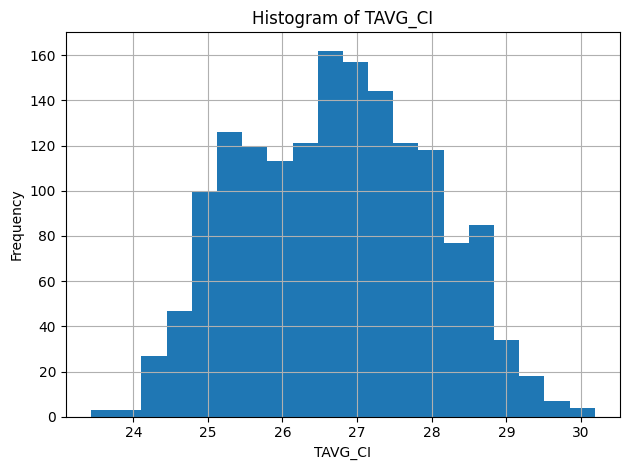

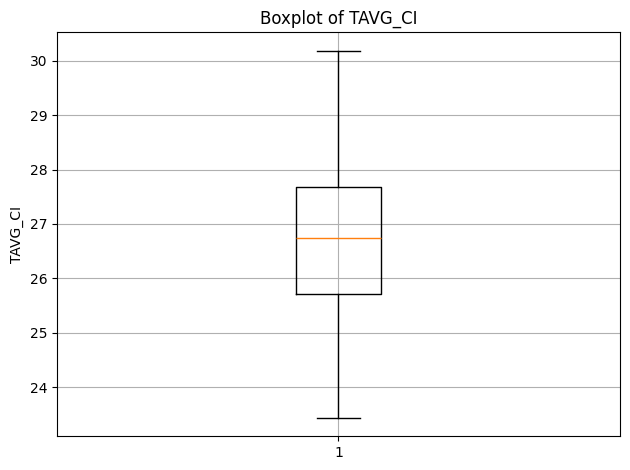

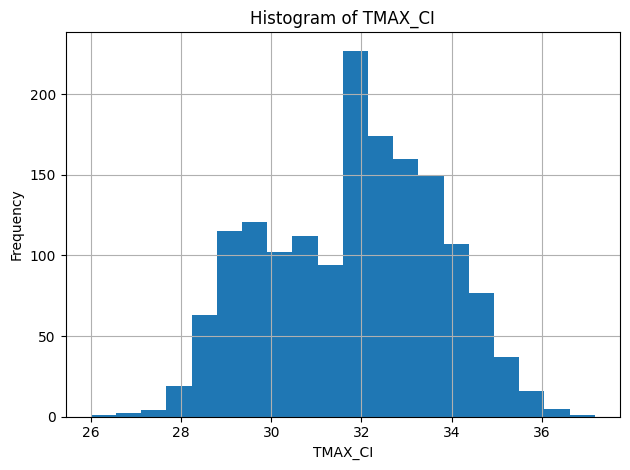

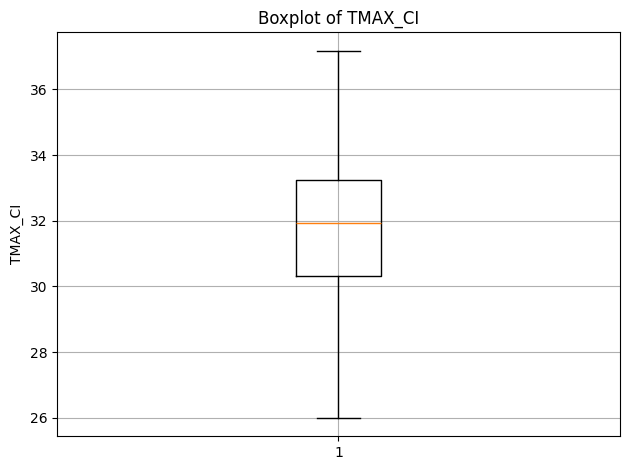

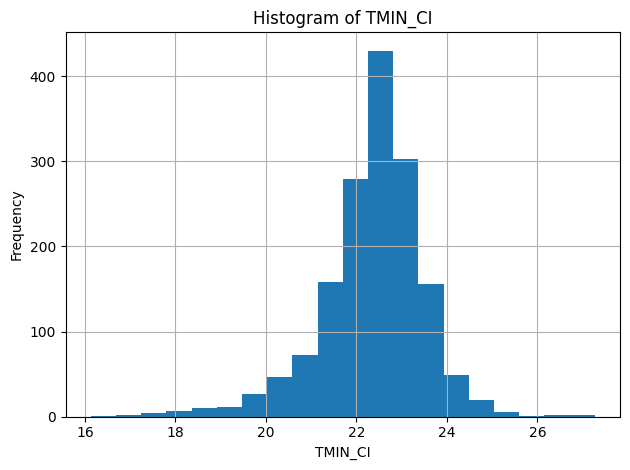

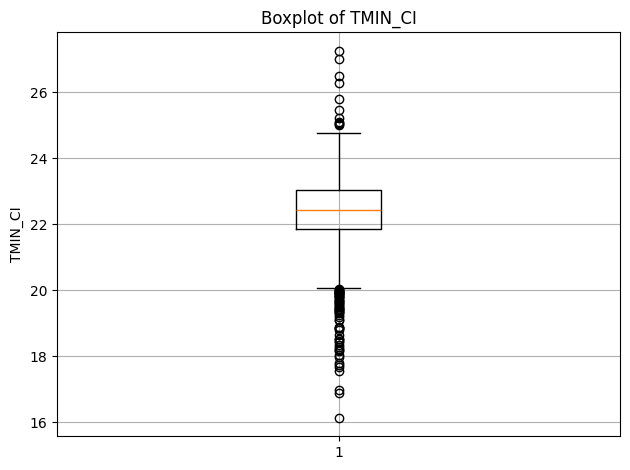

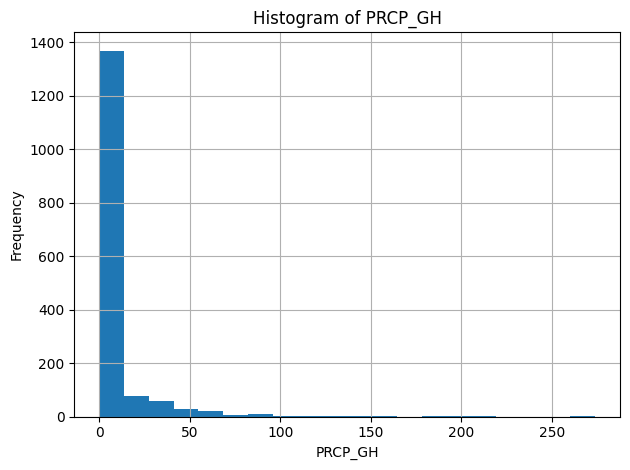

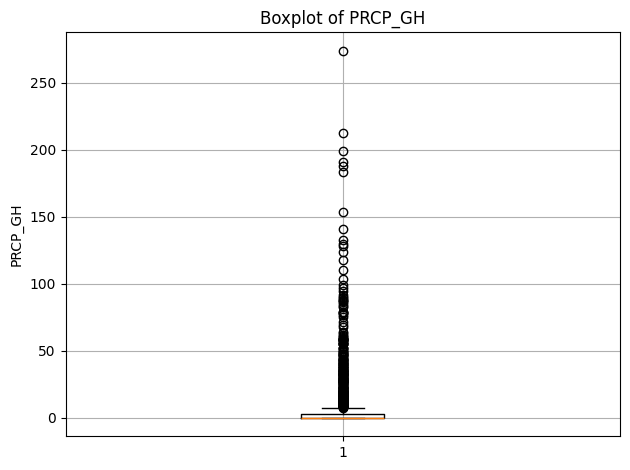

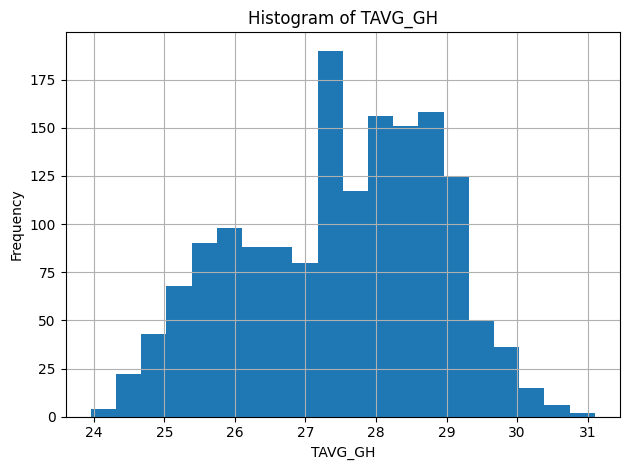

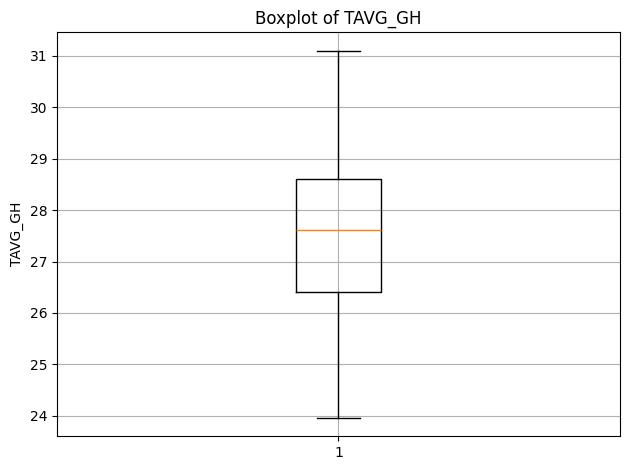

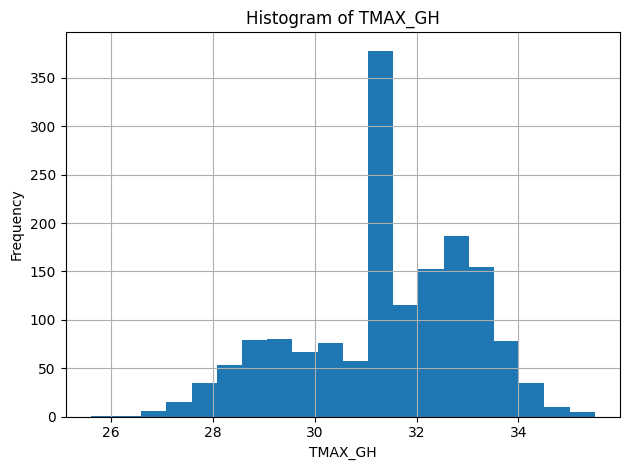

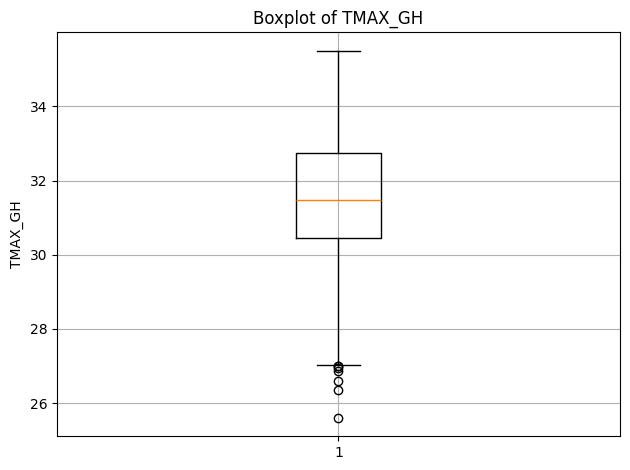

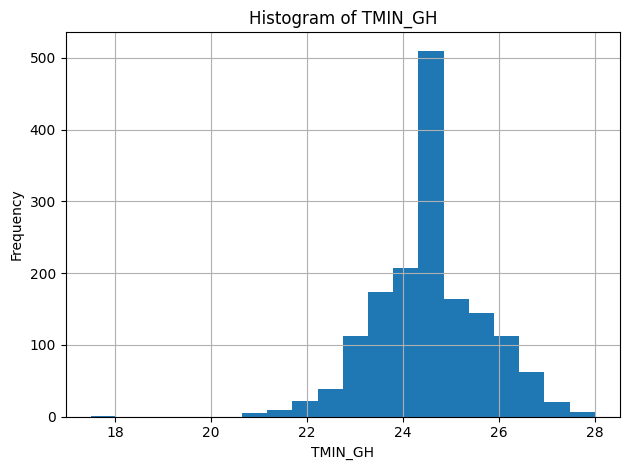

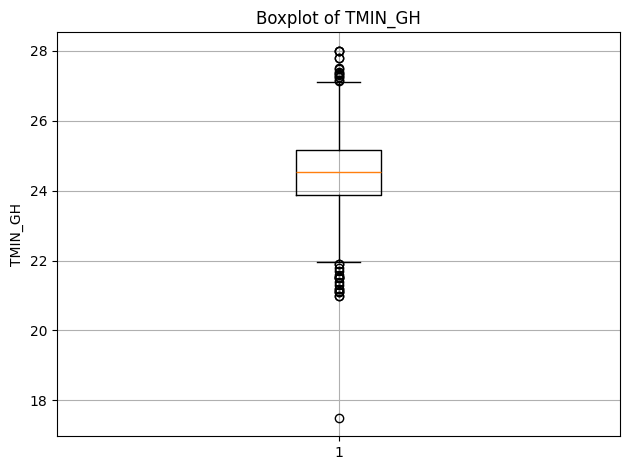


=== CORRELATION MATRIX ===
            price   PRCP_CI   TAVG_CI   TMAX_CI   TMIN_CI   PRCP_GH   TAVG_GH  \
price    1.000000  0.097951  0.102416  0.104127  0.169083  0.075693  0.139900   
PRCP_CI  0.097951  1.000000 -0.193639 -0.310497  0.192706  0.323958 -0.265657   
TAVG_CI  0.102416 -0.193639  1.000000  0.862197  0.488595 -0.011584  0.825662   
TMAX_CI  0.104127 -0.310497  0.862197  1.000000  0.169760 -0.082480  0.841372   
TMIN_CI  0.169083  0.192706  0.488595  0.169760  1.000000  0.113702  0.266719   
PRCP_GH  0.075693  0.323958 -0.011584 -0.082480  0.113702  1.000000 -0.096578   
TAVG_GH  0.139900 -0.265657  0.825662  0.841372  0.266719 -0.096578  1.000000   
TMAX_GH  0.115205 -0.290542  0.718712  0.780765  0.127373 -0.112182  0.853917   
TMIN_GH  0.206922 -0.172401  0.661639  0.625594  0.330421 -0.166048  0.746211   

          TMAX_GH   TMIN_GH  
price    0.115205  0.206922  
PRCP_CI -0.290542 -0.172401  
TAVG_CI  0.718712  0.661639  
TMAX_CI  0.780765  0.625594  
TMIN_CI  0.

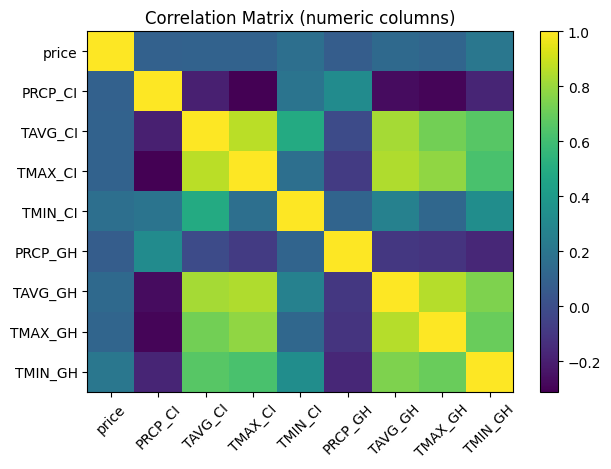

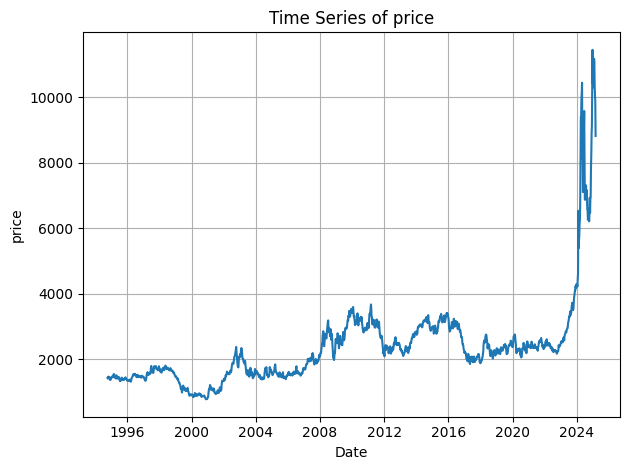

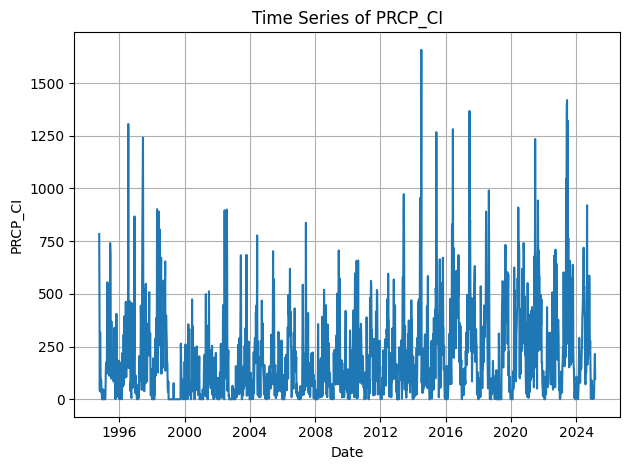

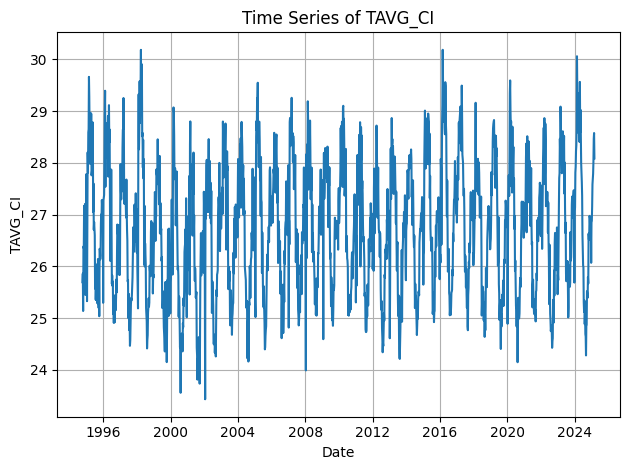

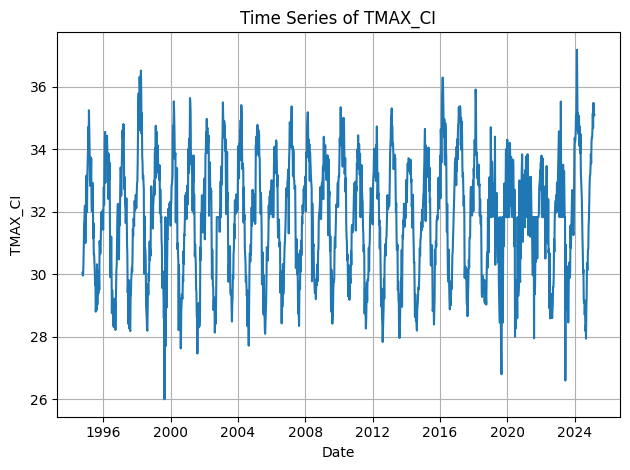

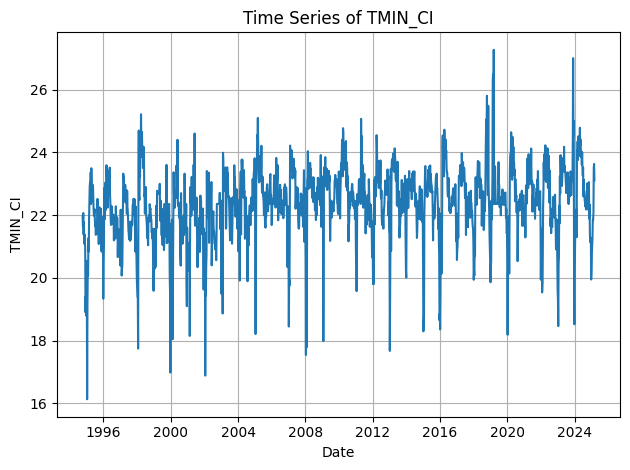

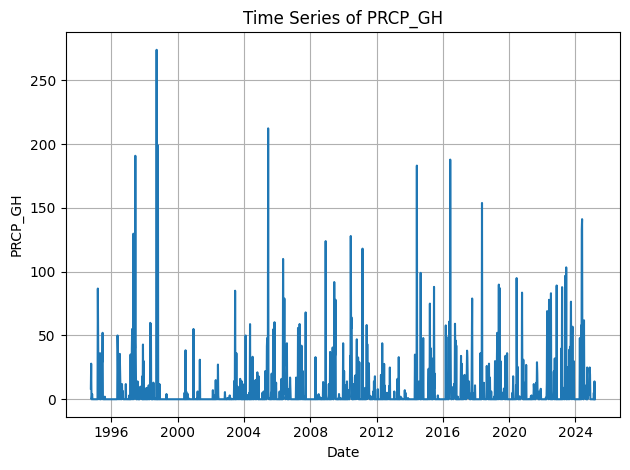

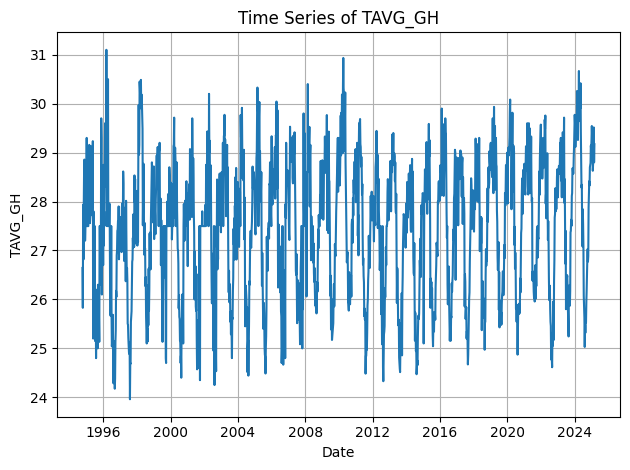

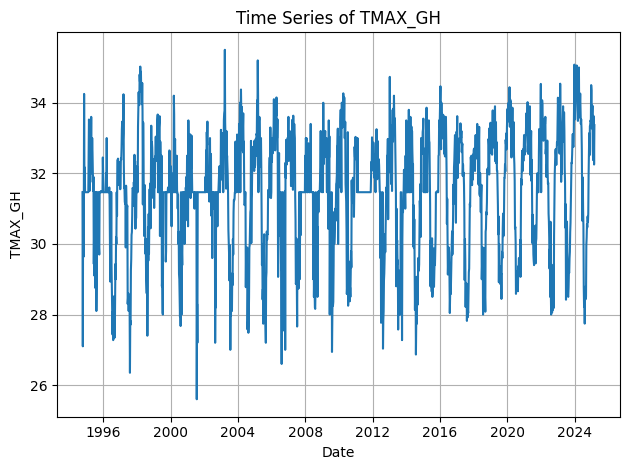

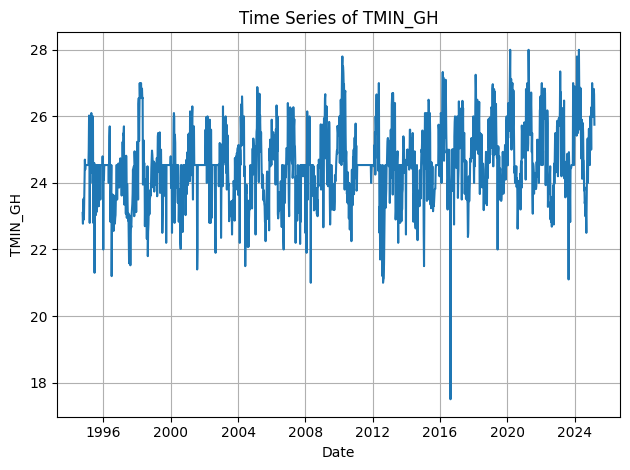

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) LOAD THE DATA
df = pd.read_csv("/content/drive/MyDrive/STA457_Project/weekly_aggregated_data.csv", parse_dates=["date"])

# 2) BASIC CHECKS
print("=== HEAD ===")
print(df.head())

print("\n=== INFO ===")
print(df.info())

print("\n=== DESCRIBE ===")
print(df.describe())

# 3) MISSING VALUE ANALYSIS
print("\n=== MISSING VALUES (per column) ===")
print(df.isnull().sum())

# Optional: Bar plot of missing values
plt.figure()
df.isnull().sum().plot(kind="bar")
plt.title("Count of Missing Values per Column")
plt.xlabel("Columns")
plt.ylabel("Number of Missing")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) DISTRIBUTIONS (HISTOGRAMS & BOXPLOTS)
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop("Date", errors="ignore")

for col in numeric_cols:
    # --- Histogram ---
    plt.figure()
    plt.hist(df[col].dropna(), bins=20)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Boxplot ---
    plt.figure()
    plt.boxplot(df[col].dropna())
    plt.ylabel(col)
    plt.title(f"Boxplot of {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5) CORRELATION ANALYSIS
# Drop any non-numeric columns (like Date) before computing correlation
numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()
print("\n=== CORRELATION MATRIX ===")
print(corr_matrix)

# Plot correlation matrix
plt.figure()
plt.imshow(corr_matrix, aspect="auto")
plt.colorbar()
plt.xticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=45)
plt.yticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns)
plt.title("Correlation Matrix (numeric columns)")
plt.tight_layout()
plt.show()

# 6) TIME SERIES LINE PLOTS
# We'll plot each numeric column over time to see trends
df.set_index("date", inplace=True)  # set Date as index for time-series plots


for col in numeric_cols:
    plt.figure()
    plt.plot(df.index, df[col])
    plt.title(f"Time Series of {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
